# Goal:

* Basic assessment on whether the diffusive boundary layer of the ultracentrifugation tubes may be causing the broad OTU abundance distributions (most span the entire gradient)

# Literative on diffusive boundary layers (DBL)

## DNA binding to plastics

* [blog on adsorbtion](http://core-genomics.blogspot.com/2014/03/how-long-can-you-store-your-ngs.html)
  * 5-25% DNA adsorbed to polypropylene
  * [Belotserkovkii](http://www.ncbi.nlm.nih.gov/pubmed/8539626)
  * [whitepaper](https://www.researchgate.net/publication/228649995_Avoiding_DNA_loss_and_denaturation_upon_storage_in_plastic_microtubes)
  * [Gaillard and Strauss](http://www.sciencedirect.com/science/article/pii/S1366212008701016)
* http://www.sciencedirect.com/science/article/pii/S0003269703000514
* http://ac.els-cdn.com/S0003269785712717/1-s2.0-S0003269785712717-main.pdf?_tid=5920ba7a-9acf-11e5-94e8-00000aacb362&acdnat=1449265285_3576aa92de9eb1df4e7f299ef05389ff
* Beckman ultra-cfg tubes:
  * http://www.centrifugebybeckman.com/?page_id=788/?pi_ad_id=62362322836&gclid=CLHP0c3gxckCFYQfHwodfp8CBg
  * surface properties to 'prevent adherence of nucleic acids and proteins'
  

# Init

In [2]:
%load_ext rpy2.ipython

In [259]:
%%R
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)
library(rootSolve)

# Setting parameters

In [51]:
%%R
SIPdbFile = '/home/nick/db/SIPdb/DOE_SIP_db.xlsx'
sheet.id = 'Fractions'

In [215]:
%%R

# tube characteristics
tube_diam__mm = 13
tube_height__mm = 48
tube_round_bottom_height__mm = 6.5
tube_capacity__ml = 4.7
tube_composition = 'polypropylene'

# rotor 
rotor_id = 'TLA-110'
r_min__mm = 26
r_ave__mm = 37.2
r_max__mm = 48.5
frac_tube_angle = 90 

# cfg run
## rpm of run
rpm = 55000
## angular velocity (w^2)
angular_velocity = 17545933.74
## average particle density
ave_gradient_density = 1.70
## beta^o  
BetaO = 1.14e9  # CsCl at density of 1.70
## position of particle at equilibrium 
particle_at_eq = 3.78 
## max 13C shift
max_13C_shift_in_BD = 0.036
## min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
## max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD

# diffusive boundary layer (DBL)
DBL_size_range__micron = c(10,100)


# misc
fraction_vol__cm3 = 0.1

In [198]:
%%R
# rotor angle
## sin(x) = opp / hypo
## x = sin**-1(opp/hypo)

rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max__mm - r_min__mm 
hyp = tube_height__mm
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [213]:
%%R
x = r_max__mm - r_min__mm 
hyp = tube_height__mm
asin(x / hyp)

[1] 0.4878751


## Isoconcentration point 

* Formula 6.7 in Birnine and Rickwood 1978

In [193]:
%%R
# isoconcentration point
r_top = r_min__mm / 10
r_bottom = r_max__mm / 10
I__cm = sqrt((r_top**2 + r_top * r_bottom + r_bottom**2)/3)

cat('Isoconcentration point:', I__cm, '(cm)\n')

Isoconcentration point: 3.781204 (cm)


## Fraction size range (based on previous run data)

In [101]:
%%R
# loading SIPdb info
df.SIPdb = read_excel(SIPdbFile, sheet=sheet.id)
df.SIPdb %>% head(n=3) %>% as.data.frame 

      sample_id gradient_date fractionation_date fraction_id well_id     RI
1 13C-Ami.D3.R1    2015-01-27         2015-01-30           1      A1 1.4075
2 13C-Ami.D3.R1    2015-01-27         2015-01-30           2      B1 1.4071
3 13C-Ami.D3.R1    2015-01-27         2015-01-30           3      C1 1.4067
  RI_corrected       BD volume experiment
1       1.4059 1.770113     NA    fullCyc
2       1.4055 1.765742     NA    fullCyc
3       1.4051 1.761371     NA    fullCyc


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-0.00219  0.00328  0.00437  0.00440  0.00546  0.01748      110 


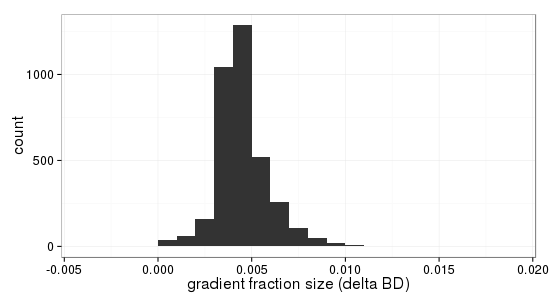

In [102]:
%%R -w 550 -h 300
# BD range
df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(BD_range = BD - lead(BD)) 

df.SIPdb$BD_range %>% summary %>% print

ggplot(df.SIPdb, aes(BD_range)) + 
    geom_histogram(binwidth=0.001) +
    labs(x = 'gradient fraction size (delta BD)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [103]:
%%R
# fraction size range (1st & 3rd quartiles)
frac_size_range__BD = c(0.003, 0.005)

## band width distribution

* tube height of fraction = volume of fraction 

$100 ul = 0.1 cm^3$

$v = pi*r^2*h$

$h = v / (pi * r^2)$

In [154]:
%%R
frac_size__ul = 100
frac_vol__cm3 = frac_size__ul / 1000
tube_radius__cm = tube_diam__mm / (2 * 10)
frac_height = frac_vol__cm3 / (pi * tube_radius__cm **2)
cat('The height of each fraction in vertically oriented tube:', frac_height, '(cm)\n')
cat('(Just applies to cylinder)\n')

The height of each fraction in vertically oriented tube: 0.07533962 (cm)
(Just applies to cylinder)


In [172]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


In [141]:
%%R
df.SIPdb.f = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD)) %>% head %>% print

Source: local data frame [6 x 3]
Groups: sample_id [3]

       sample_id fractionation_date BD_heaviest
           (chr)             (time)       (dbl)
1 12C-Con.D14.R1         2015-02-23    1.769020
2 12C-Con.D14.R1         2015-07-17    1.771206
3  12C-Con.D1.R2         2015-02-16    1.769020
4  12C-Con.D1.R2         2015-06-26    1.773391
5 12C-Con.D30.R1         2015-03-09    1.772298
6 12C-Con.D30.R1         2015-05-04    1.766835


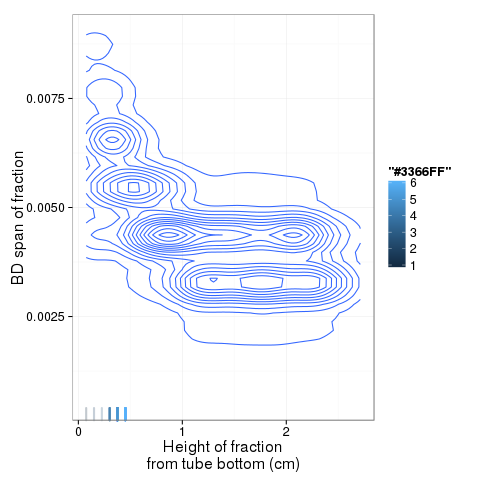

In [174]:
%%R 
# plotting fraction vs fraction height in verticle tube
## calculating culmulative fraction height
df.SIPdb = df.SIPdb %>%
    ungroup() %>%
    mutate(frac_height = frac_height) %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(cum_frac_height = cumsum(frac_height))

## first fraction kept (max BD fraction used for each gradient)
heavy.frac = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD))
heavy.frac = inner_join(heavy.frac, df.SIPdb, c('sample_id' = 'sample_id',
                                        'fractionation_date' = 'fractionation_date',
                                        'BD_heaviest' = 'BD')) %>%
    select(sample_id, fractionation_date, BD_heaviest, cum_frac_height, BD_range, fraction_id) 


## plotting
ggplot(df.SIPdb, aes(cum_frac_height, BD_range)) +
    geom_density2d() +
    geom_rug(data=heavy.frac, sides='b', size=1, alpha=0.25, aes(color=fraction_id)) +
    #geom_point(alpha=0.25) +
    #stat_smooth(formula= y ~ poly(x, 2), method='lm') +
    labs(x='Height of fraction\nfrom tube bottom (cm)', y='BD span of fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [175]:
%%R
# summary of where in tube the heaviest fraction is used (cm from the bottom)
heavy.frac$cum_frac_height %>% summary %>% print
heavy.frac$fraction_id %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07534 0.37670 0.37670 0.38420 0.45200 0.45200 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     5.0     5.0     5.1     6.0     6.0 


#### Figure description:

* rug plot is showing the heaviest gradient fraction actually used further in SIP pipeline

#### Notes: 

* similar to Flamm et al., 1972 on fixed angle rotors
* near the bottom of the tube, the density changes most rapidly
  * smaller bandwidths at bottom of the tube

## Converting verticle bandwidth to angled bandwidth

* Flamm et al., 1966

Width of band in angled rotor (at speed):
 
$w = \frac{V}{\pi*r*b}$

Width of band in vertical position:

$w' = \frac{V}{\pi*r^2}$

Where:

* V = common volume
* r = tube radius
* b = band ellipse major axis (at speed)

# surface to volume ratio of each fraction

## Rough approximation

In [19]:
%%R
frac_size__mm = 1
tube_diam__mm = 13
DBL_size__mm = 0.1

In [20]:
%%R
tube_circ = 2 * pi * tube_diam__mm**2
nonDBL_circ = tube_circ - 2 * DBL_size__mm
frac_vol = tube_circ * frac_size__mm
nonDBL_vol = nonDBL_circ * frac_size__mm
DBL_vol = frac_vol - nonDBL_vol
DBL_to_frac = DBL_vol / frac_vol * 100

cat('Percent of fraction that is DBL: ', DBL_to_frac, '%\n', sep='')

Percent of fraction that is DBL: 0.0188349%


# Stability of gradient

$t = 0.3(r_b - r_t)^2$

* r unit: cm
* t unit: hours

In [75]:
%%R
r_t = r_min__mm / 10
r_b = r_max__mm / 10
t = 0.3 * (r_b - r_t)**2
cat('Time span of stability:', t, '(h)\n')

Time span of stability: 1.51875 (h)


# Tube position of fraction (during spin; at equilibrium)

* angled tube: this sets up the diffusive boundary layer
* Determining tube location of each density band:
  * For density range of interest:
    * determine location range in tube
* Determining where each density band touched on the tube during ultracentrifugation:
  * gradient is basically a set of ellipsoids (angled cross sections) of the tube (cylinder)
    * Need to determine the ellipsoid main axis diameter for each position in the gradient
  * For each location range in tube (see above):
    * Determine the ellipsoid major axis length
    * Determine the tube side wall locations (bottom & top) for the ellipsoid
      * This is the location of the diffusive boundary layer for the ellispoid

## Tube location of each density band

Density at a given radius from axis of rotation:

$ x = \big(\frac{w^2}{2*\beta^o} * (r_d^2 - I^2)\big) + D$

* where:
  * $x$ = density at a given radius
  * $w^2$ = angular velocity
  * $\beta^o$ = beta coef
  * $r_d$ = radius of desired density (cm)
  * $I$ = isocencentration point (cm)
  * $D$ = average density of gradient
  

Radius from axis of rotation for a given density:

$ r_d = \sqrt{\frac{(x - D) * 2\beta^o}{w^2} + I^2} $





In [196]:
%%R
BD2radius = function(x, D, BetaO, w2, I){
    sqrt( ((x-D)*2*BetaO/w2) + I^2)
#    x = ((D_x - D_ave) * 2 * BetaO) / w2
#    return(x + I)
}
  
min_BD_r = BD2radius(min_BD, ave_gradient_density, BetaO, angular_velocity, I__cm)
max_BD_r = BD2radius(max_BD, ave_gradient_density, BetaO, angular_velocity, I__cm)

cat('isoconcentration point:', I__cm, '\n')
cat('radius range for BD-min to BD-max: ', min_BD_r, 'to', max_BD_r, '\n')

isoconcentration point: 3.781204 
radius range for BD-min to BD-max:  3.289207 to 4.895445 


## Geometry of a angled cross sections in the ultracentrifugation tube

In [208]:
%%R
tube_diam__cm = tube_diam__mm / 10
elps_main_axis__cm = tube_diam__cm / deg2rad(rotor_tube_angle) 
cat('ellipsoid major axis length in tube (cylinder) cross section:', elps_main_axis__cm, '\n')

ellipsoid major axis length in tube (cylinder) cross section: 2.664616 


In [212]:
%%R
# radius position where rounded tube bottom affects ellipsoid major axis 
## should just be round bottom diameter
round_bottom_diam__cm = tube_diam__mm / 10
r_round_bottom = r_max__mm / 10 - round_bottom_diam__cm
cat('radius position where round bottom comes into play:', r_round_bottom, '\n')

radius position where round bottom comes into play: 3.55 


#### Notes:

* Need to take into account round bottom because it falls into the radius range for BD min-max

In [178]:
%%R
frac_size__ul = 100
frac_vol__cm3 = frac_size__ul / 1000
tube_radius__cm = tube_diam__mm / (2 * 10)
frac_height = frac_vol__cm3 / (pi * tube_radius__cm **2)
cat('The height of each fraction in vertically oriented tube:', frac_height, '(cm)\n')
cat('(Just applies to cylinder)\n')

The height of each fraction in vertically oriented tube: 0.07533962 (cm)
(Just applies to cylinder)


In [179]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

# need to determine the tube height of each of these first 6 fractions

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


In [180]:
%%R
df.SIPdb.f = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD)) %>% head %>% print

Source: local data frame [6 x 3]
Groups: sample_id [3]

       sample_id fractionation_date BD_heaviest
           (chr)             (time)       (dbl)
1 12C-Con.D14.R1         2015-02-23    1.769020
2 12C-Con.D14.R1         2015-07-17    1.771206
3  12C-Con.D1.R2         2015-02-16    1.769020
4  12C-Con.D1.R2         2015-06-26    1.773391
5 12C-Con.D30.R1         2015-03-09    1.772298
6 12C-Con.D30.R1         2015-05-04    1.766835


# Tube position of fraction in vertical position

* For each density band:
  * Determine the height in the tube
  * This will rely on empirical data to determine the relationship between BD and tube height (vertical position)

## Relationship between density and tube height

* volume ~ BD
* tube height ~ volume

### tube height ~ volume

Cylinder volume:

$v = \pi r^2$ h

Sphere volume:

$v = \frac{4}{3} \pi r^3$

Spherical cap volume:

$V = \frac{\pi * h^2}{3} (3r-h)$

[1] 0.2360648


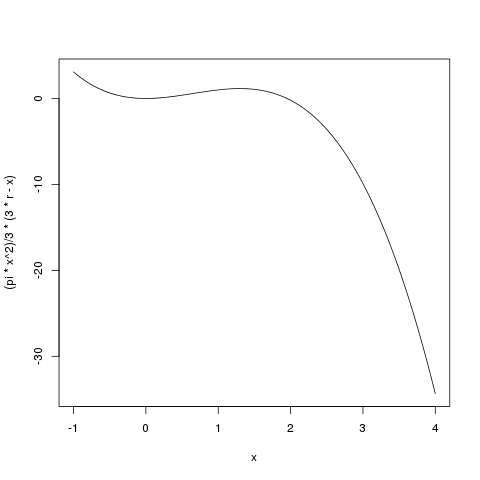

In [258]:
%%R 
# relationship: volume ~ height
r = 0.65

f = function(x){x**3 - 3*r*x**2 + 3*0.1/pi}
uniroot.all(f, c(0, r*2)) %>% print
curve((pi*x**2)/3 * (3*r - x), from=-1, to=4)

In [266]:
%%R
# converting cylinder volume to cylinder height (cm)
cyl_vol2height = function(v, r){v / (pi * r**2)}

cyl_vol2height(0.1, 0.65)

[1] 0.07533962


In [417]:
%%R
# converting sphere cap volume to sphere height (cm)
sphr_vol2height = function(v, r){
    # h**3 - 3*r*h**2 + (3v / pi) = 0
    f = function(x){x**3 - 3*r*x**2 + 3*v/pi}
    roots = uniroot.all(f, c(0, r*2))
    if(length(roots) > 1){
        root_str = paste(roots, sep=',')
        cat('ERROR: Number of roots > 1 for volume:', v, '\n roots:', root_str, '\n')
        stop()
    } else if (length(roots) == 0){
        cat('WARNING: no roots for volume:', v, '\n')
        roots = NA
    }
    return(roots[1])
}

sphr_vol2height(0.1, 0.65)

[1] 0.2360648


In [418]:
%%R
# -- check on calculation of sphere hight from bottom --
# height of rounded tube bottom 
h_bottom = tube_diam__mm / (2*10)
# volume of rounded portion of tube
v_bottom = (4/3 * pi * h_bottom**3)/2

stopifnot(sphr_vol2height(v_bottom, 0.65) == h_bottom)

In [431]:
%%R

# function to convert volume filling cfg tube to tube height
tubeVol2height = function(v, r=0.65){
    # v = volume (cm^3)
    # r = sphere radius
    stopifnot(length(v) == 1)
    
    sphr_cap_vol = (4/3 * pi * r**3)/2
    
    if(v <= sphr_cap_vol){
        # height does not extend to cylinder
        h = sphr_vol2height(v, r)
    } else {
        # height = sphere_cap + cylinder
        sphr_cap_height = sphr_vol2height(sphr_cap_vol, r)
        h =  sphr_cap_height + cyl_vol2height(v - sphr_cap_vol, r)
    }
    return(h)
}


# test
tube_radius__cm = tube_diam__mm / (2*10)
vol = 0.1   # 100 ul

vols = seq(0, 4, 0.1)
sapply(vols, tubeVol2height, r=tube_radius__cm)

 [1] 0.0000000 0.2360648 0.3449723 0.4348016 0.5161206 0.5932149 0.6687044
 [8] 0.7440440 0.8193836 0.8947232 0.9700628 1.0454025 1.1207421 1.1960817
[15] 1.2714213 1.3467609 1.4221006 1.4974402 1.5727798 1.6481194 1.7234590
[22] 1.7987986 1.8741383 1.9494779 2.0248175 2.1001571 2.1754967 2.2508364
[29] 2.3261760 2.4015156 2.4768552 2.5521948 2.6275344 2.7028741 2.7782137
[36] 2.8535533 2.9288929 3.0042325 3.0795722 3.1549118 3.2302514


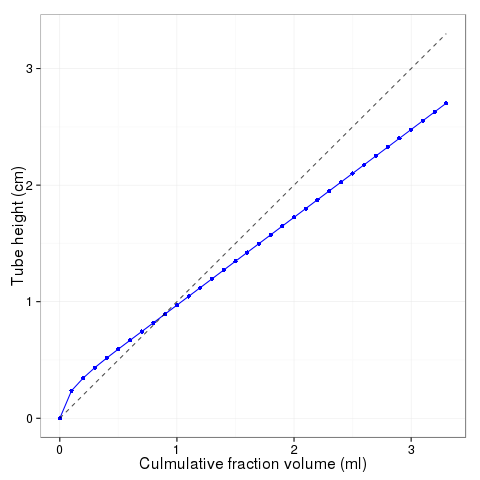

In [420]:
%%R
# plotting

n_fracs = 32
x = seq(0, 0.1*(n_fracs+1), 0.1)
df = data.frame('x' = x, 'y' = sapply(x, tube_vol2height))
ggplot(df, aes(x, y)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    stat_function(fun = function(x) x, linetype='dashed', alpha=0.7) +
    labs(x='Culmulative fraction volume (ml)',
         y='Tube height (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### fraction volume ~ BD

* determining from empirical data

In [421]:
%%R
# loading SIPdb info
df.SIPdb = read_excel(SIPdbFile, sheet=sheet.id)
df.SIPdb %>% head(n=3) %>% as.data.frame 

      sample_id gradient_date fractionation_date fraction_id well_id     RI
1 13C-Ami.D3.R1    2015-01-27         2015-01-30           1      A1 1.4075
2 13C-Ami.D3.R1    2015-01-27         2015-01-30           2      B1 1.4071
3 13C-Ami.D3.R1    2015-01-27         2015-01-30           3      C1 1.4067
  RI_corrected       BD volume experiment
1       1.4059 1.770113     NA    fullCyc
2       1.4055 1.765742     NA    fullCyc
3       1.4051 1.761371     NA    fullCyc


In [422]:
%%R
# BD range
df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(BD_range = BD - lead(BD)) 

In [423]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


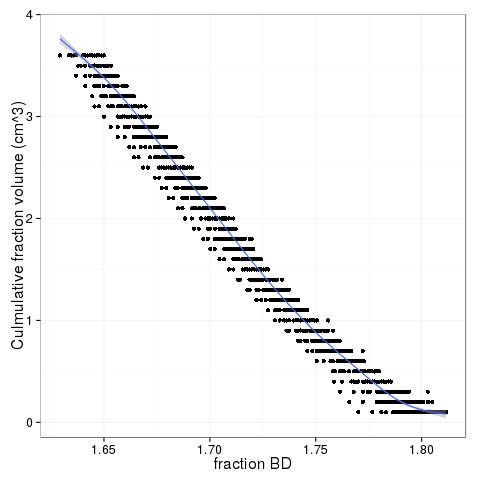

In [424]:
%%R 
# plotting fraction vs fraction height in verticle tube
## calculating culmulative fraction height

df.SIPdb = df.SIPdb %>%
    ungroup() %>%
    mutate(frac_vol = fraction_vol__cm3) %>%  
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(culm_frac_vol = cumsum(frac_vol))

## plotting
ggplot(df.SIPdb, aes(BD, culm_frac_vol)) +
    geom_point() +
    geom_smooth() +
    labs(y='Culmulative fraction volume (cm^3)', x='fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


Call:
lm(formula = y ~ x + I(x^2) + I(x^3), data = dataset)

Coefficients:
(Intercept)            x       I(x^2)       I(x^3)  
    -2599.5       4664.9      -2771.9        545.9  



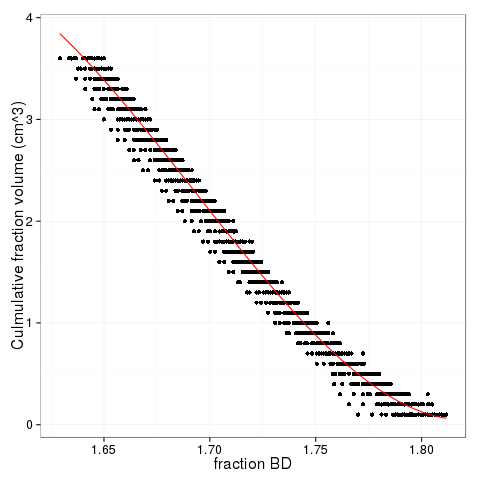

In [425]:
%%R 
# curve fit for: culm_frac_vol ~ fraction_BD

dataset = df.SIPdb %>%
    select(BD, culm_frac_vol) %>%
    rename('x' = BD, 'y' = culm_frac_vol) %>%
    as.data.frame

fit = lm(y~x+I(x^2)+I(x^3), data=dataset)
fit %>% print
dataset$y_pred = predict(fit)

ggplot(dataset, aes(x)) +
    geom_point(aes(y=y)) +
    geom_line(aes(y=y_pred), color='red') +
    labs(y='Culmulative fraction volume (cm^3)', x='fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [459]:
%%R
BD2tubeVol = function(BD){
    if(BD > 1.809){
        cat('WARNING: BD value', BD, 'is > 1.809, where tube volume = 0', 
            'Setting BD to 1.809\n')
        BD = 1.809
    }
    tube_vol = 545.9*BD**3 - 2771.9*BD**2 + 4664.9*BD - 2599.5
    if(tube_vol < 0){
        cat('WARNING: tube volume < 0 for BD: ', BD, 
            '\n Setting volume to 0\n')
        tube_vol = 0
    }
    return(tube_vol)
}

# check
BD2tubeVol(1.65) %>% print
BD2tubeVol(1.7) %>% print
BD2tubeVol(1.75) %>% print
BD2tubeVol(1.8) %>% print
BD2tubeVol(1.9) %>% print

[1] 3.338287
[1] 2.0457
[1] 0.8140625
[1] 0.0528
 Setting volume to 0
[1] 0


### tube height ~ BD

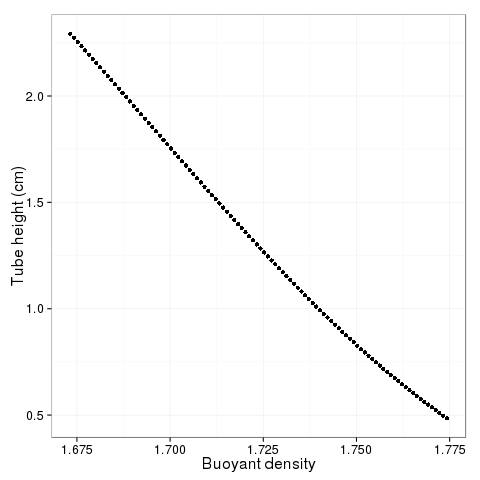

In [436]:
%%R
BD_gradient = rev(seq(min_BD, max_BD, 0.001))

# wrapper function for BD2tubeVol & tubeVol2height
BD2tubeHeight = function(BD, r){
    stopifnot(length(BD) == 1)
    v = BD2tubeVol(BD)
    tubeVol2height(v, r)    
}

h = sapply(BD_gradient, BD2tubeHeight,  r=tube_radius__cm)
df = data.frame('BD' = BD_gradient, 'height' = h)

ggplot(df, aes(BD, h)) +
    geom_point() +
    labs(x='Buoyant density',
         y='Tube height (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [468]:
%%R
max_BD

[1] 1.7744


 Setting volume to 0
 Setting volume to 0
 Setting volume to 0
 Setting volume to 0


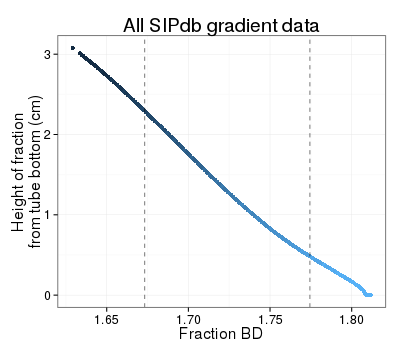

In [477]:
%%R -w 400 -h 350
# plotting relationship between BD and tube height for SIPdb data
df.SIPdb = df.SIPdb %>%
    mutate(tube_height__cm = sapply(BD, BD2tubeHeight, r=tube_radius__cm))


## plotting
ggplot(df.SIPdb, aes(BD, tube_height__cm, color=-fraction_id)) +
    #geom_point(alpha=0.5, shape='O') +
    geom_point() +
    geom_vline(xintercept=min_BD, linetype='dashed', alpha=0.5) +
    geom_vline(xintercept=max_BD, linetype='dashed', alpha=0.5) +
    labs(title='All SIPdb gradient data', 
         y='Height of fraction\nfrom tube bottom (cm)', 
         x='Fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

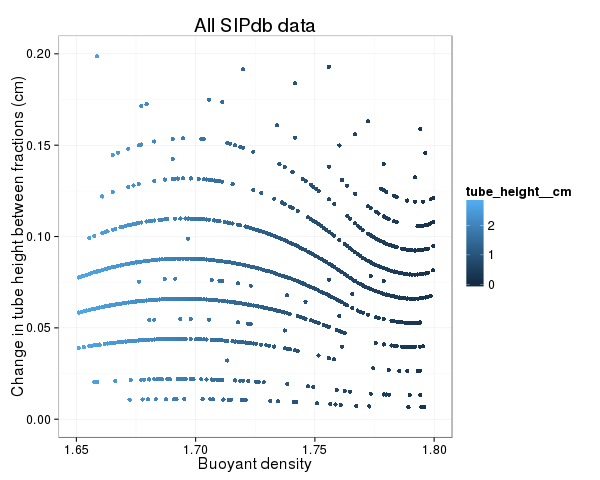

In [504]:
%%R -w 600
# do the BD bands expand further up in the gradient?

df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(delta_tube_height = lead(tube_height__cm) - tube_height__cm) 

df.SIPdb.f = df.SIPdb %>%
    filter(delta_tube_height > 0)

ggplot(df.SIPdb.f, aes(BD, delta_tube_height, color=tube_height__cm)) +
    geom_point() +
    scale_x_continuous(limits=c(1.65, 1.80)) +
    scale_y_continuous(limits=c(0, 0.2)) +
    labs(title='All SIPdb data',
         x='Buoyant density',
         y='Change in tube height between fractions (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## density at a given radius

$\text{density} = \text{angular_velocity} / (2*B^o) * (\text{radius_desired}^2 - \text{isoconcentration_point}^2)) + \text{ave_grad_density}$

# radius for a given density: r ~ BD

## radius of the isoconcentration point from cfg center (AKA: r.p)
### position of the particle at equilibrium 
buoyant.density2radius = function(x){ sqrt( ((x-D)*2*B/w) + I^2 ) }

In [83]:
%%R
r_des = 6.78   # cm
(angular_velocity / (2*BetaO) * (r_des**2 - I__cm**2)) + ave_gradient_density

[1] 2.017078


In [71]:
%%R
cat('min BD:', min_BD, '\nmax BD:', max_BD, "\n")

min BD: 1.67323 
max BD: 1.7744 


# gradient length (cm) at equillibrium

# DBL overlap in fractions 

* max delta BD between fraction in rotor orientation vs when the orientation set to verticle for fractionation